# Capstone Project - The Battle of Neighborhoods (Week 1)
#### Clearly define a problem or an idea of your choice, where you would need to leverage the Foursquare location data to solve or execute. Remember that data science problems always target an audience and are meant to help a group of stakeholders solve a problem, so make sure that you explicitly describe your audience and why they would care about your problem.
#### Problem
Population of City of Toronto is rising every year, which brings more requirements on the city services, as well as the medical services. This report uses Foursquare location data, and Toront census data to determine which neighbourhood needs to have a new medical center the most. 
#### Target Audience
This report can provide City of Toronto a clear view to make a decision to select a location of a new medical center.
#### Describe the data that you will be using to solve the problem or execute your idea. Remember that you will need to use the Foursquare location data to solve the problem or execute your idea. You can absolutely use other datasets in combination with the Foursquare location data. So make sure that you provide adequate explanation and discussion, with examples, of the data that you will be using, even if it is only Foursquare location data.
#### Data Set
* First, get Toronto neighbourhoods Postal Codes from [Wikipedia](https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M) , and get the neighbourhood longitude & latitude data from geocoder. Combine these two dataframe to get the neighbourhood location dataframe.
* Second, get Toronto neighbourhoods population (2011 census) from [City of Toronto](https://www.toronto.ca/city-government/data-research-maps/neighbourhoods-communities/neighbourhood-profiles/)
* At last, get vendue info from Foursquare for the neighbourhoods North York and Downtown Toronto


In [2]:
!pip install geocoder

     |████████████████████████████████| 102kB 8.9MB/s ta 0:00:011


In [3]:
!conda install -c conda-forge geopy --yes

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    geopy-2.0.0                |     pyh9f0ad1d_0          63 KB  conda-forge
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    openssl-1.1.1g             |       h516909a_1         2.1 MB  conda-forge
    certifi-2020.6.20          |   py36h9f0ad1d_0         151 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0          conda-forge
    geopy:           

In [4]:
!conda install -c conda-forge folium=0.5.0

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    folium-0.5.0               |             py_0          45 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    altair-4.1.0               |             py_1         614 KB  conda-forge
    branca-0.4.1               |             py_0          26 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         713 KB

The following NEW packages will be INSTALLED:

    altair:  4.1.0-py_1 conda-forge
    branca:  0.4.1-py_0 conda-forge
    folium:  0.5.0-py_0 conda-forge
    vincent: 0.4.4-py_1 conda-forge


folium-0.5.0         | 45 KB     | ##################################### | 1

In [112]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)
import json
from geopy.geocoders import Nominatim
import requests
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium
from bs4 import BeautifulSoup

# get Toronto Postal Codes
source = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text

soup = BeautifulSoup(source, 'lxml')

table = soup.find_all('table')[0]
table_rows = table.find_all('tr')
res = []
for tr in table_rows:
    td = tr.find_all('td')
    row = [tr.text.strip() for tr in td if tr.text.strip()]
    if row:
        res.append(row)
neighbourhoods = pd.DataFrame(res, columns=["Postal Code", "Borough", "Neighbourhood"])

noBorough = neighbourhoods[neighbourhoods['Borough'] == 'Not assigned' ].index
# Delete these row indexes from dataFrame
neighbourhoods.drop(noBorough , inplace=True)

neighbourhoods = neighbourhoods.groupby(['Postal Code', 'Borough'])['Neighbourhood'].apply(lambda x: ','.join(x)).reset_index()

neighbourhoods.head()



,Postal Code,Borough,Neighbourhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [113]:
# get Toronto latitude and longitude data
body = client_8cc2199f4de34c34b8ea2a5417ea34b6.get_object(Bucket='capstoneproject-donotdelete-pr-h7mqe4wdojwsnu',Key='Geospatial_Coordinates.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

geo = pd.read_csv(body)
geo.head()


,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [114]:
# add latitude, longitude to the neighbourhoods dataset
neighbourhoods = neighbourhoods.merge(geo,on='Postal Code')
neighbourhoods.head(10)

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
6,M1K,Scarborough,"Kennedy Park, Ionview, East Birchmount Park",43.727929,-79.262029
7,M1L,Scarborough,"Golden Mile, Clairlea, Oakridge",43.711112,-79.284577
8,M1M,Scarborough,"Cliffside, Cliffcrest, Scarborough Village West",43.716316,-79.239476
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848


In [17]:
# The code was removed by Watson Studio for sharing.

,Neighbourhood,Population,"Under $5,000","$5,000 to $9,999","$10,000 to $14,999","$15,000 to $19,999","$20,000 to $29,999","$30,000 to $39,999","$40,000 to $49,999","$50,000 to $59,999","$60,000 to $79,999","$80,000 to $99,999","$100,000 and over","$100,000 to $124,999","$125,000 and over"
0,Agincourt North,30279,260,160,165,495,810,1120,1055,780,1445,1165,1655,805,865
1,Agincourt South-Malvern West,21988,175,115,190,220,560,865,930,720,1130,725,1215,575,650
2,Alderwood,11904,105,35,65,120,480,515,430,510,745,565,1080,520,560
3,Annex,29177,955,680,790,1130,1385,1460,1385,1340,1755,1115,3545,1065,2480
4,Banbury-Don Mills,26918,180,125,245,665,1150,1150,1200,1125,1750,880,3260,965,2305


In [111]:
# merge the population table to the postal code table
n_pop = neighbourhoods.merge(population,on='Neighbourhood')
n_pop.head(10)

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Population_x,"Under $5,000_x","$5,000 to $9,999_x","$10,000 to $14,999_x","$15,000 to $19,999_x","$20,000 to $29,999_x","$30,000 to $39,999_x","$40,000 to $49,999_x","$50,000 to $59,999_x","$60,000 to $79,999_x","$80,000 to $99,999_x","$100,000 and over_x","$100,000 to $124,999_x","$125,000 and over_x",Population_y,"Under $5,000_y","$5,000 to $9,999_y","$10,000 to $14,999_y","$15,000 to $19,999_y","$20,000 to $29,999_y","$30,000 to $39,999_y","$40,000 to $49,999_y","$50,000 to $59,999_y","$60,000 to $79,999_y","$80,000 to $99,999_y","$100,000 and over_y","$100,000 to $124,999_y","$125,000 and over_y"
0,M1G,Scarborough,Woburn,43.770992,-79.216917,53350,750,320,755,1200,2005,2230,2310,2120,2575,1725,2325,1085,1220,53350,750,320,755,1200,2005,2230,2310,2120,2575,1725,2325,1085,1220
1,M1J,Scarborough,Scarborough Village,43.744734,-79.239476,16609,245,180,430,390,765,895,845,465,670,295,715,285,430,16609,245,180,430,390,765,895,845,465,670,295,715,285,430
2,M2H,North York,Hillcrest Village,43.803762,-79.363452,17656,175,145,125,615,540,600,595,580,915,750,1505,600,910,17656,175,145,125,615,540,600,595,580,915,750,1505,600,910
3,M2K,North York,Bayview Village,43.786947,-79.385975,17671,375,110,170,205,540,740,740,860,1070,770,1740,590,1165,17671,375,110,170,205,540,740,740,860,1070,770,1740,590,1165
4,M4A,North York,Victoria Village,43.725882,-79.315572,17182,225,110,285,650,1025,1040,925,710,895,590,830,450,385,17182,225,110,285,650,1025,1040,925,710,895,590,830,450,385
5,M4E,East Toronto,The Beaches,43.676357,-79.293031,21130,305,100,205,275,600,795,660,825,1370,890,3325,755,2565,21130,305,100,205,275,600,795,660,825,1370,890,3325,755,2565
6,M4H,East York,Thorncliffe Park,43.705369,-79.349372,19225,160,155,265,580,1070,1275,905,685,820,445,360,180,165,19225,160,155,265,580,1070,1275,905,685,820,445,360,180,165
7,M6C,York,Humewood-Cedarvale,43.693781,-79.428191,14108,180,215,280,500,780,695,660,600,765,485,1420,405,1020,14108,180,215,280,500,780,695,660,600,765,485,1420,405,1020
8,M9L,North York,Humber Summit,43.756303,-79.565963,12525,110,0,40,90,360,595,495,415,655,450,545,290,260,12525,110,0,40,90,360,595,495,415,655,450,545,290,260
9,M9N,York,Weston,43.706876,-79.518188,18170,325,155,450,625,1140,1095,1180,690,885,610,745,410,335,18170,325,155,450,625,1140,1095,1180,690,885,610,745,410,335


In [122]:
# Find all Medical Centers in Toronto
def getNearbyMedicalCenter(name, latitudes, longitudes, radius=500):
    CLIENT_ID = 'UZF51JLJCNRPSCTOVICJLC2ZNH4QBLHAXAUDDKCFA4ZYXFA4' # your Foursquare ID
    CLIENT_SECRET = 'IZULKGFRHMY4K451Z3HJAYGUZGUZETCLSB0RGY3P4I0DUFTH' # your Foursquare Secret
    VERSION = '20200810' # Foursquare API version
    LIMIT = 100 # limit of number of venues returned by Foursquare API
    radius = 500 # define radius
    categoryId='4bf58dd8d48988d104941735'


    venues_list=[]
    for name, lat, lng in zip(name, latitudes, longitudes):
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            categoryId)

       #results = requests.get(url).json()["response"]['groups'][0]['items']
        results = requests.get(url).json()
        results = results['response']['groups'][0]['items']
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_mc = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_mc.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_mc)
#nearby_venues.head()
toronto_mc = getNearbyMedicalCenter(name=neighbourhoods['Neighbourhood'],
                                   latitudes=neighbourhoods['Latitude'],
                                   longitudes=neighbourhoods['Longitude']
                                  )
toronto_mc = toronto_mc.merge(neighbourhoods,on='Neighbourhood')
toronto_mc.head(100)

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Postal Code,Borough,Latitude,Longitude
0,"Malvern, Rouge",43.806686,-79.194353,Extendicare Rouge Valley,43.803974,-79.189386,Medical Center,M1B,Scarborough,43.806686,-79.194353
1,"Guildwood, Morningside, West Hill",43.763573,-79.188711,CML HealthCare,43.762568,-79.191970,Medical Center,M1E,Scarborough,43.763573,-79.188711
2,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Woburn Medical Centre,43.766631,-79.192286,Medical Center,M1E,Scarborough,43.763573,-79.188711
3,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Life Labs,43.766802,-79.192486,Medical Lab,M1E,Scarborough,43.763573,-79.188711
4,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Simply Align Rehabilitation,43.766634,-79.192275,Chiropractor,M1E,Scarborough,43.763573,-79.188711
5,Cedarbrae,43.773136,-79.239476,physiomed,43.774745,-79.240938,Medical Center,M1H,Scarborough,43.773136,-79.239476
6,Cedarbrae,43.773136,-79.239476,Physiomed Scarborough - Ellesmere,43.775003,-79.240841,Medical Center,M1H,Scarborough,43.773136,-79.239476
7,Cedarbrae,43.773136,-79.239476,Maple Clinic,43.774840,-79.240644,Doctor's Office,M1H,Scarborough,43.773136,-79.239476
8,Cedarbrae,43.773136,-79.239476,Dr. Meneses Health Clinic,43.774960,-79.240851,Doctor's Office,M1H,Scarborough,43.773136,-79.239476
9,Cedarbrae,43.773136,-79.239476,ACTIVE CARE CHIROPRACTIC CLINIC,43.775038,-79.240834,Chiropractor,M1H,Scarborough,43.773136,-79.239476


#### The analystic is based on the above datasets, details will be presented on the week2 project as a final report.

## Week 2 
#### Results, Decision, and Conclusion Sections

In [123]:
total_mc=toronto_mc.assign(amount=1)
total_mc.head()
total_mc=total_mc.groupby('Borough')
total_mc.head()


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Postal Code,Borough,Latitude,Longitude,amount
0,"Malvern, Rouge",43.806686,-79.194353,Extendicare Rouge Valley,43.803974,-79.189386,Medical Center,M1B,Scarborough,43.806686,-79.194353,1
1,"Guildwood, Morningside, West Hill",43.763573,-79.188711,CML HealthCare,43.762568,-79.191970,Medical Center,M1E,Scarborough,43.763573,-79.188711,1
2,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Woburn Medical Centre,43.766631,-79.192286,Medical Center,M1E,Scarborough,43.763573,-79.188711,1
3,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Life Labs,43.766802,-79.192486,Medical Lab,M1E,Scarborough,43.763573,-79.188711,1
4,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Simply Align Rehabilitation,43.766634,-79.192275,Chiropractor,M1E,Scarborough,43.763573,-79.188711,1
43,Hillcrest Village,43.803762,-79.363452,cmcc clinic,43.803875,-79.363883,Medical Center,M2H,North York,43.803762,-79.363452,1
44,"Fairview, Henry Farm, Oriole",43.778517,-79.346556,CML HealthCare,43.778744,-79.346954,Medical Center,M2J,North York,43.778517,-79.346556,1
45,"Fairview, Henry Farm, Oriole",43.778517,-79.346556,Fairview Mall Medical Building,43.778640,-79.347731,Doctor's Office,M2J,North York,43.778517,-79.346556,1
46,"Fairview, Henry Farm, Oriole",43.778517,-79.346556,Comfort Keepers Home Care,43.779780,-79.341891,Medical Center,M2J,North York,43.778517,-79.346556,1
47,"Fairview, Henry Farm, Oriole",43.778517,-79.346556,Summit Heights Dental Fairview,43.778568,-79.347876,Dentist's Office,M2J,North York,43.778517,-79.346556,1


In [69]:
!conda install -c conda-forge geopandas

Solving environment: / ^C
failed

CondaError: KeyboardInterrupt



In [70]:
!pip install geopandas matplotlib

     |████████████████████████████████| 972kB 9.0MB/s eta 0:00:01
     |████████████████████████████████| 10.9MB 22.3MB/s eta 0:00:01
     |████████████████████████████████| 1.0MB 33.8MB/s eta 0:00:01
     |████████████████████████████████| 14.7MB 9.9MB/s eta 0:00:01


In [77]:
!pip install shapely==1.7.1
!pip install geopandas==0.2.1
!pip install geojsonio==0.0.3

In [117]:
import geopandas as gpd
import geojsonio
#geojsonio.embed(geo.to_json(na='drop'))
geo_j=geo.to_json()


In [124]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches

toronto_mc.columns = list(map(str, toronto_mc.columns))

grouped=toronto_mc.groupby(['Borough']).count()
grouped.rename(columns={'Venue':'Count'}, inplace=True)
grouped.reset_index(inplace=True)
grouped=grouped[['Borough','Count']]
grouped.head(100)


,Borough,Count
0,Central Toronto,36
1,Downtown Toronto,414
2,East Toronto,25
3,East York,17
4,Etobicoke,35
5,Mississauga,2
6,North York,99
7,Scarborough,43
8,West Toronto,27
9,York,10


In [126]:
tt_map = folium.Map(location=[43.65,-79.38], zoom_start=12)
tt_map.choropleth(
    geo_data=geo_j,
    data=grouped,
    columns=['Borough', 'Count'],
    #key_on='neighbourhood.Neighbourhood',
    fill_color='YlOrRd', 
    fill_opacity=20, 
    line_opacity=10,
    legend_name='Toronto Medical Center'
)

tt_map

TypeError: 'AxesSubplot' object is not iterable

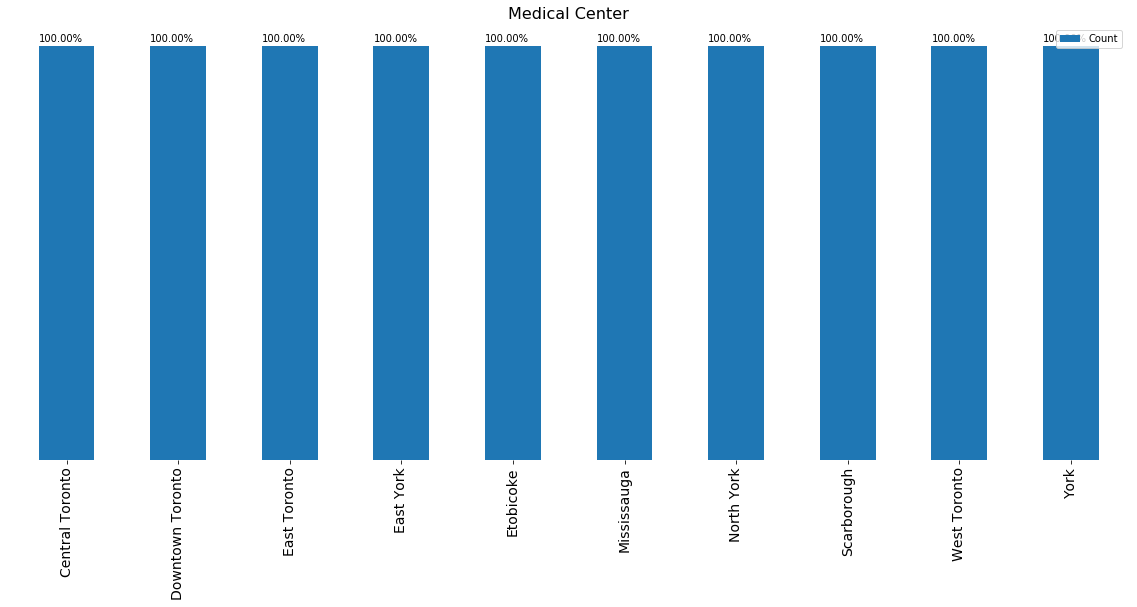

In [125]:
#count, bin_edges=np.histogram(grouped['Count'])
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches

#grouped.rename(columns={'Unnamed: 0': 'Neighbourhood'}, inplace=True)
grouped.set_index('Borough', inplace=True)

grouped = (grouped.div(grouped.sum(1), axis=0)).plot(kind='bar',figsize=(20,8), fontsize= 14)

plt.title("Medical Center", fontsize = 16)
plt.xticks(fontsize=14)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.yticks([])
plt.xlabel('')

for p in grouped.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    grouped.annotate('{:.2%}'.format(height), (x, y + height + 0.01),fontsize=10)

plt.show()


In [30]:
neighbourhoods_onehot = pd.get_dummies(toronto_mc[['Neighbourhood']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
neighbourhoods_onehot['Neighbourhood'] = toronto_mc['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [neighbourhoods_onehot.columns[-1]] + list(neighbourhoods_onehot.columns[:-1])
neighbourhoods_onehot = neighbourhoods_onehot[fixed_columns]
neighbourhoods_onehot.head()

,Neighbourhood,Bayview Village,Hillcrest Village,Humber Summit,Humewood-Cedarvale,Scarborough Village,The Beaches,Thorncliffe Park,Weston
0,Scarborough Village,0,0,0,0,1,0,0,0
1,Hillcrest Village,0,1,0,0,0,0,0,0
2,Bayview Village,1,0,0,0,0,0,0,0
3,The Beaches,0,0,0,0,0,1,0,0
4,Thorncliffe Park,0,0,0,0,0,0,1,0


In [31]:
neighbourhoods_grouped = neighbourhoods_onehot.groupby('Neighbourhood').mean().reset_index()
neighbourhoods_grouped.head()

,Neighbourhood,Bayview Village,Hillcrest Village,Humber Summit,Humewood-Cedarvale,Scarborough Village,The Beaches,Thorncliffe Park,Weston
0,Bayview Village,1,0,0,0,0,0,0,0
1,Hillcrest Village,0,1,0,0,0,0,0,0
2,Humber Summit,0,0,1,0,0,0,0,0
3,Humewood-Cedarvale,0,0,0,1,0,0,0,0
4,Scarborough Village,0,0,0,0,1,0,0,0


In [35]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Type'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Type'.format(ind+1))
neighbourhoods_sorted = pd.DataFrame(columns=columns)
neighbourhoods_sorted['Neighbourhood'] = neighbourhoods_grouped['Neighbourhood']

for ind in np.arange(neighbourhoods_grouped.shape[0]):
    neighbourhoods_sorted.iloc[ind, 1:] = return_most_common_venues(neighbourhoods_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_sorted.head()


,Neighbourhood,1st Most Common Type,2nd Most Common Type,3rd Most Common Type,4th Most Common Type,5th Most Common Type
0,Bayview Village,Bayview Village,Weston,Thorncliffe Park,The Beaches,Scarborough Village
1,Hillcrest Village,Hillcrest Village,Weston,Thorncliffe Park,The Beaches,Scarborough Village
2,Humber Summit,Humber Summit,Weston,Thorncliffe Park,The Beaches,Scarborough Village
3,Humewood-Cedarvale,Humewood-Cedarvale,Weston,Thorncliffe Park,The Beaches,Scarborough Village
4,Scarborough Village,Scarborough Village,Weston,Thorncliffe Park,The Beaches,Humewood-Cedarvale


In [110]:
# set number of clusters
kclusters = 4

neighbourhoods_grouped_clustering = neighbourhoods_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(neighbourhoods_grouped_clustering)
# add clustering labels
#neighbourhoods_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

neighbourhoods_merged = toronto_mc

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
neighbourhoods_merged = neighbourhoods_merged.join(neighbourhoods_sorted.set_index('Neighbourhood'), on='Neighbourhood')

neighbourhoods_merged.head(100) 


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Cluster Labels,1st Most Common Type,2nd Most Common Type,3rd Most Common Type,4th Most Common Type,5th Most Common Type
0,Scarborough Village,43.744734,-79.239476,in balance chiropractic + acupuncture clinic,43.745801,-79.240190,Chiropractor,0,Scarborough Village,Weston,Thorncliffe Park,The Beaches,Humewood-Cedarvale
1,Hillcrest Village,43.803762,-79.363452,cmcc clinic,43.803875,-79.363883,Medical Center,3,Hillcrest Village,Weston,Thorncliffe Park,The Beaches,Scarborough Village
2,Bayview Village,43.786947,-79.385975,Canadian Wellness Clinic Dr. Yancy Chow,43.787558,-79.381563,Acupuncturist,0,Bayview Village,Weston,Thorncliffe Park,The Beaches,Scarborough Village
3,The Beaches,43.676357,-79.293031,Dr Jeff Shnall Beech Dental,43.680138,-79.290710,Dentist's Office,1,The Beaches,Weston,Thorncliffe Park,Scarborough Village,Humewood-Cedarvale
4,Thorncliffe Park,43.705369,-79.349372,Dr Calvin Weinryb,43.706649,-79.346754,Doctor's Office,0,Thorncliffe Park,Weston,The Beaches,Scarborough Village,Humewood-Cedarvale
5,Thorncliffe Park,43.705369,-79.349372,East York Walk-In Clinic,43.705845,-79.346260,Doctor's Office,0,Thorncliffe Park,Weston,The Beaches,Scarborough Village,Humewood-Cedarvale
6,Thorncliffe Park,43.705369,-79.349372,Motion Recovery Rehabilitation Centre,43.706649,-79.346754,Physical Therapist,0,Thorncliffe Park,Weston,The Beaches,Scarborough Village,Humewood-Cedarvale
7,Thorncliffe Park,43.705369,-79.349372,Thorncliffe Dental Centre,43.705909,-79.345821,Dentist's Office,0,Thorncliffe Park,Weston,The Beaches,Scarborough Village,Humewood-Cedarvale
8,Thorncliffe Park,43.705369,-79.349372,Al Hijamah Canada,43.706260,-79.351716,Alternative Healer,0,Thorncliffe Park,Weston,The Beaches,Scarborough Village,Humewood-Cedarvale
9,Thorncliffe Park,43.705369,-79.349372,The Midwives Clinic of East York - Don Mills,43.702541,-79.351679,Maternity Clinic,0,Thorncliffe Park,Weston,The Beaches,Scarborough Village,Humewood-Cedarvale


In [41]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(neighbourhoods_merged['Neighbourhood Latitude'], neighbourhoods_merged['Neighbourhood Longitude'], neighbourhoods_merged['Neighbourhood'], neighbourhoods_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters
